# ECG Pupillometry Pipeline

### Brain Hack School 2019
### Marcel Kaufmann

# Video Introduction

In [6]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/8ZVCNeX42_A" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')




* Pupillometry (Pupil Labs Eye Tracker)

<img src="img/pupillometer.png" width=353)> <img src="img/eye.png" width=300)>

* Heart rate and RR intervals (Polar H7 fitness tracker)

![Polar HR Monitor](https://www.polar.com/sites/default/files/product/main_images/h7_heart_rate_sensor2_main_action_30.jpg)

* ECG, EDA from Biopac (as acq files)
<div style="display: flex; justify-content: center;">
<img src="https://www.biopac.com/wp-content/uploads/bsladv-300x300.jpg")>
</div>

# Imports

In [20]:
#Existing Analysis Packages
import neurokit as nk
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
from hrvanalysis import get_time_domain_features, plot_psd, plot_distrib
from hrvanalysis import plot_poincare
from hrv.classical import time_domain

#Dynamic Time Warping
from dtwalign import dtw 

#Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%pylab inline
pylab.rcParams['figure.figsize']= (40.0,30.0) #creating bigger figure

#Awesome libraries to have..
import numpy as np
import pandas as pd
import scipy
from scipy.signal import butter, lfilter, freqz

Populating the interactive namespace from numpy and matplotlib


# Let's have a look at the data...

In [9]:
fileName='./data/M/2019_07_03_MP_Dep_Run1.txt'
df=pd.read_csv(fileName,header=[15])

In [11]:
df.tail()

,CH1,CH2,CH3,CH40,CH41,CH42,Unnamed: 6
301591,-0.918579,1.10535,0.502930,-0.256703,0.706,165.289,NaN
301592,-0.918579,1.11603,0.504150,-0.242343,0.706,165.289,NaN
301593,-0.918579,1.12473,0.505371,-0.230164,0.706,165.289,NaN
301594,-0.920105,1.13190,0.503540,-0.219675,0.706,165.289,NaN
301595,-0.920105,1.13815,0.501099,-0.210245,0.706,165.289,NaN


#### Remember... do not name your data like that!

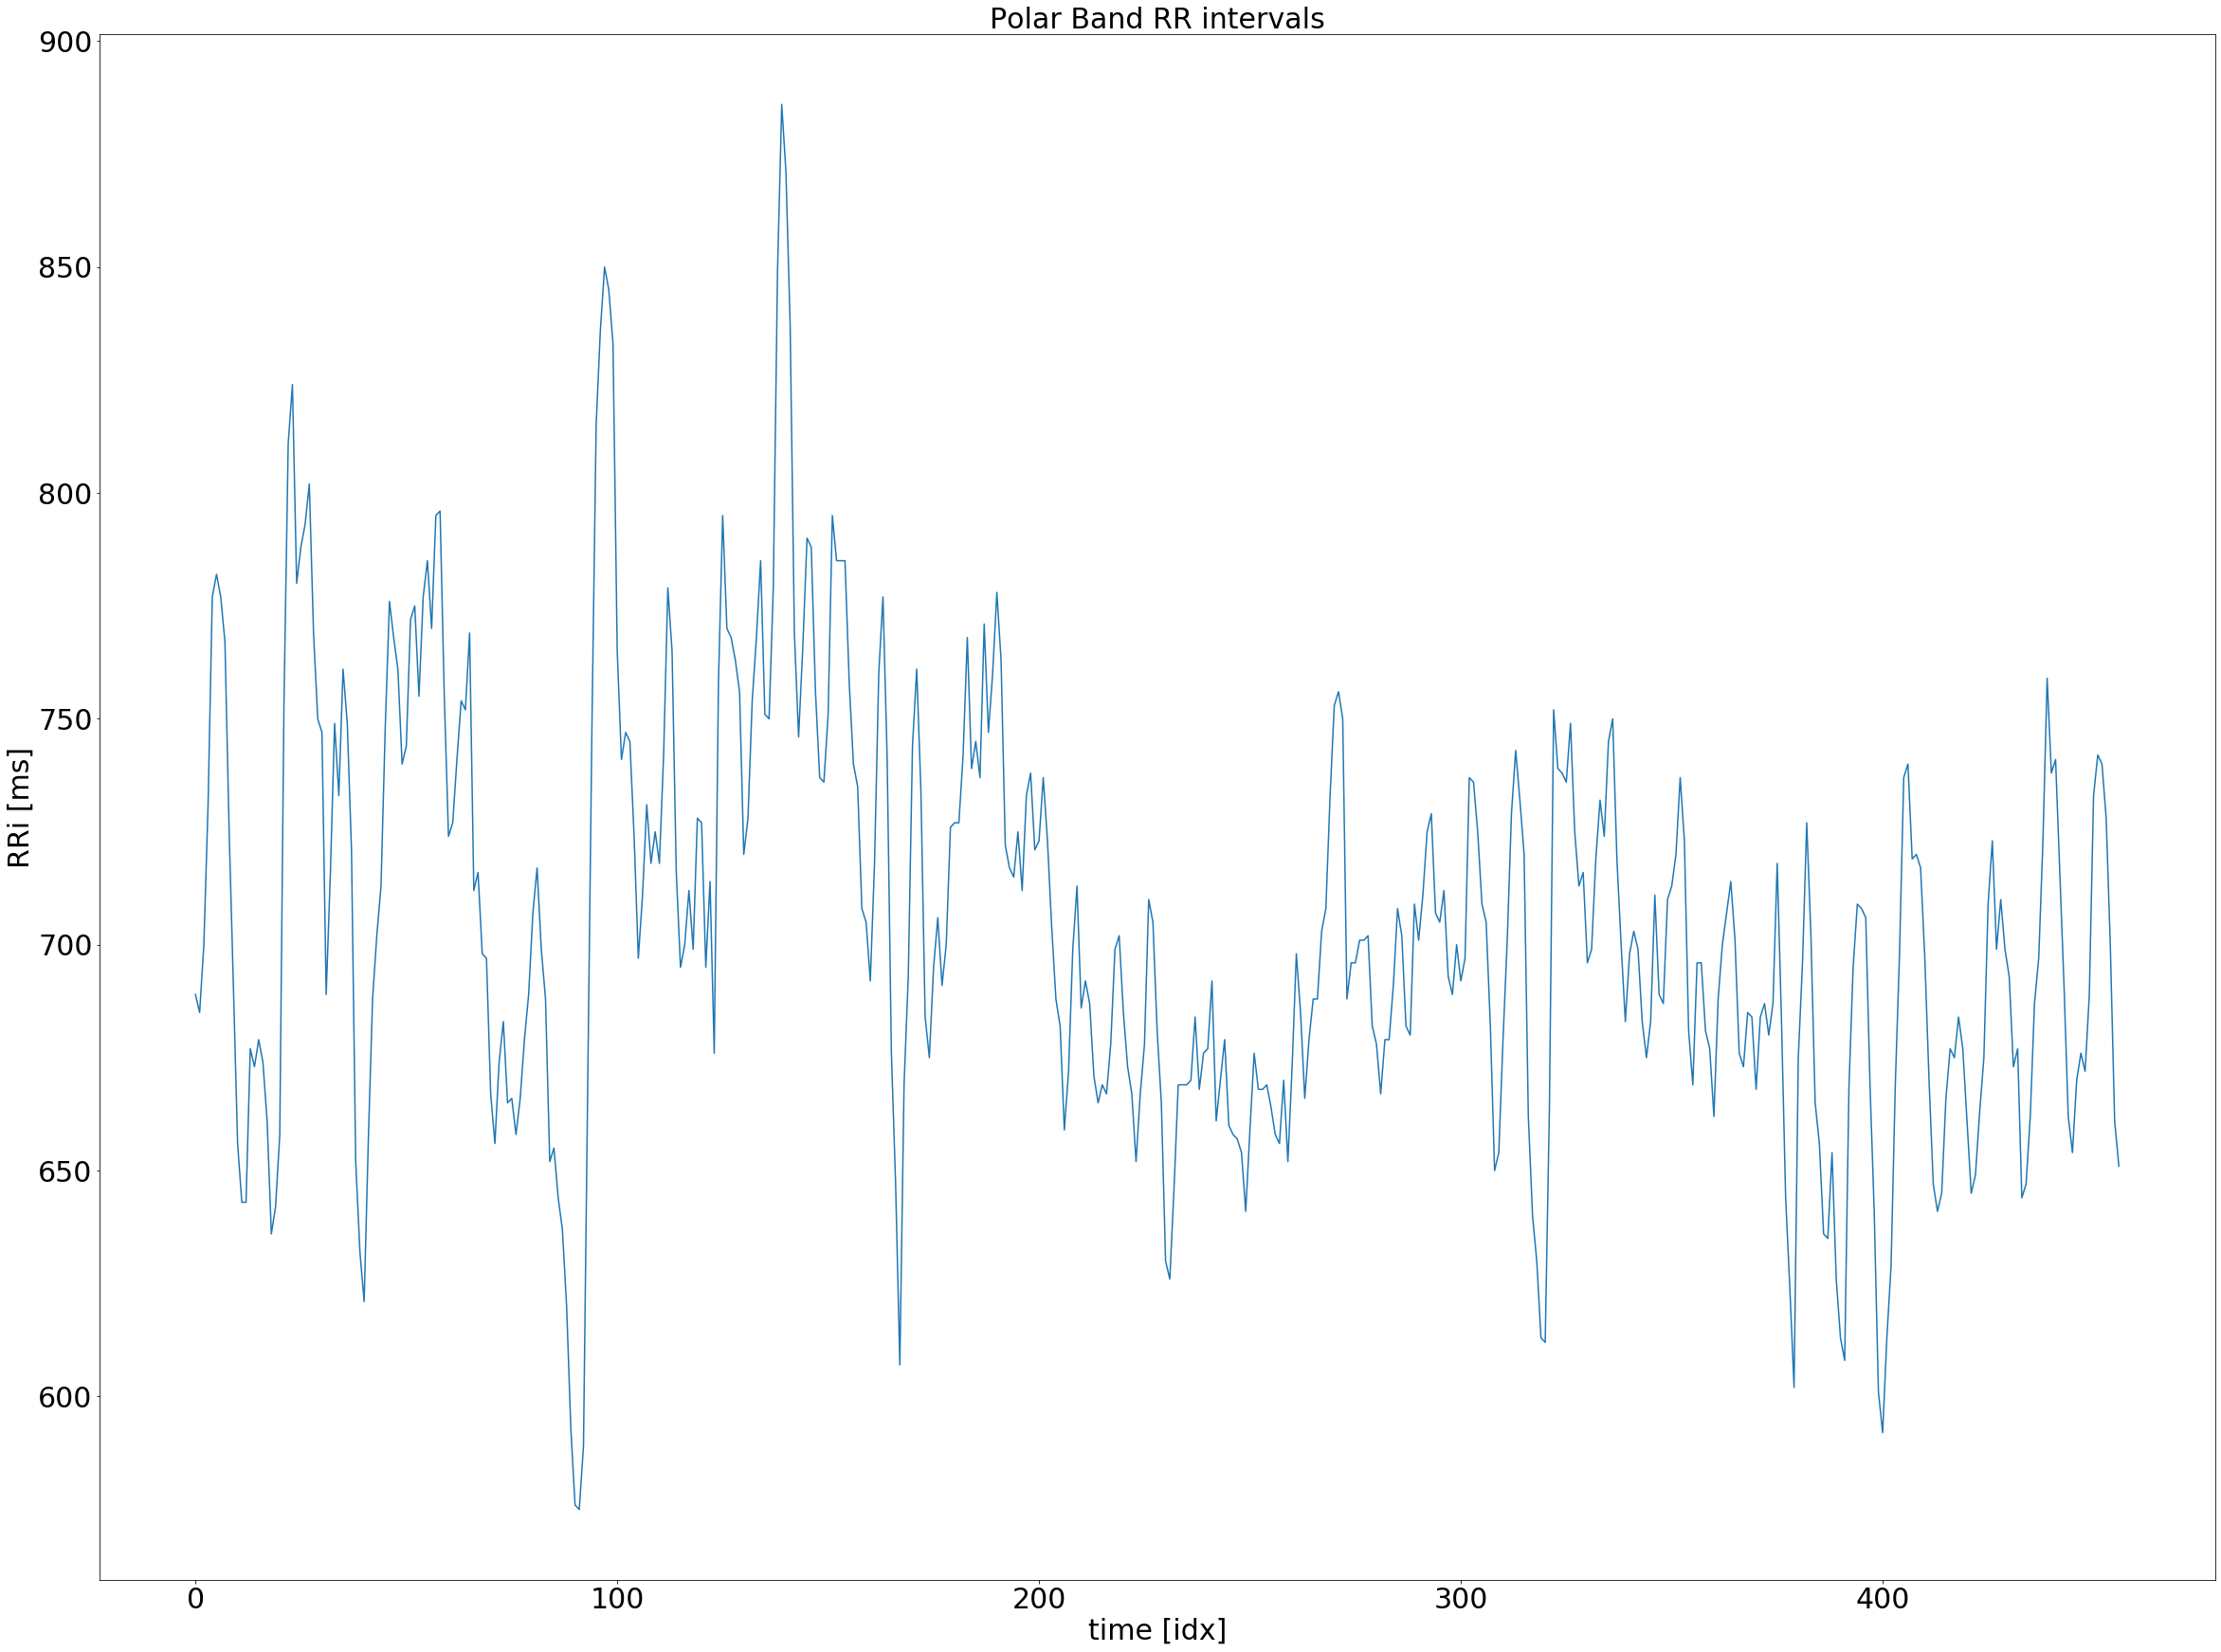

In [29]:
df_polar=pd.read_csv('./data/M/_slash_polar.csv',header=[0])
df_polar.head() #data from Polar device has been streamed as string and needs to be pre-processed and disected 
#regexp splitting at delimiter
polar_t_bpm_rr=df_polar['data'].str.split(',', expand=True)
#renaming pandas headers is an option!
polar_t_bpm_rr.columns=['t','bpm','rr']
#adding columns, too
polar_t_bpm_rr['rosbagTimestamp']=df_polar['rosbagTimestamp']
#clean artifacts in string
polar_t_bpm_rr['rr']=polar_t_bpm_rr['rr'].str.replace('"', '')

#typecasting
polar_t_bpm_rr['rr']=polar_t_bpm_rr['rr'].astype(int)
polar_t_bpm_rr['bpm']=polar_t_bpm_rr['bpm'].astype(int)

polar_t_bpm_rr.tail()
plt.title("Polar Band RR intervals",fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("time [idx]",fontsize = 30), plt.ylabel("RRi [ms]",fontsize = 30)
plt.plot(polar_t_bpm_rr['rr'])

# Outlier Removal

In [17]:
# This remove outliers from signal
rr_intervals_without_outliers = remove_outliers(rr_intervals=polar_t_bpm_rr['rr'],  low_rri=300, high_rri=2000)
# This replace outliers nan values with linear interpolation
interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method="linear")

# This remove ectopic beats from signal
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
# This replace ectopic beats nan values with linear interpolation
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

time_domain_features = get_time_domain_features(interpolated_nn_intervals)

0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.


([<matplotlib.axis.XTick at 0x1c21976c10>,
 <a list of 16 Text xticklabel objects>)

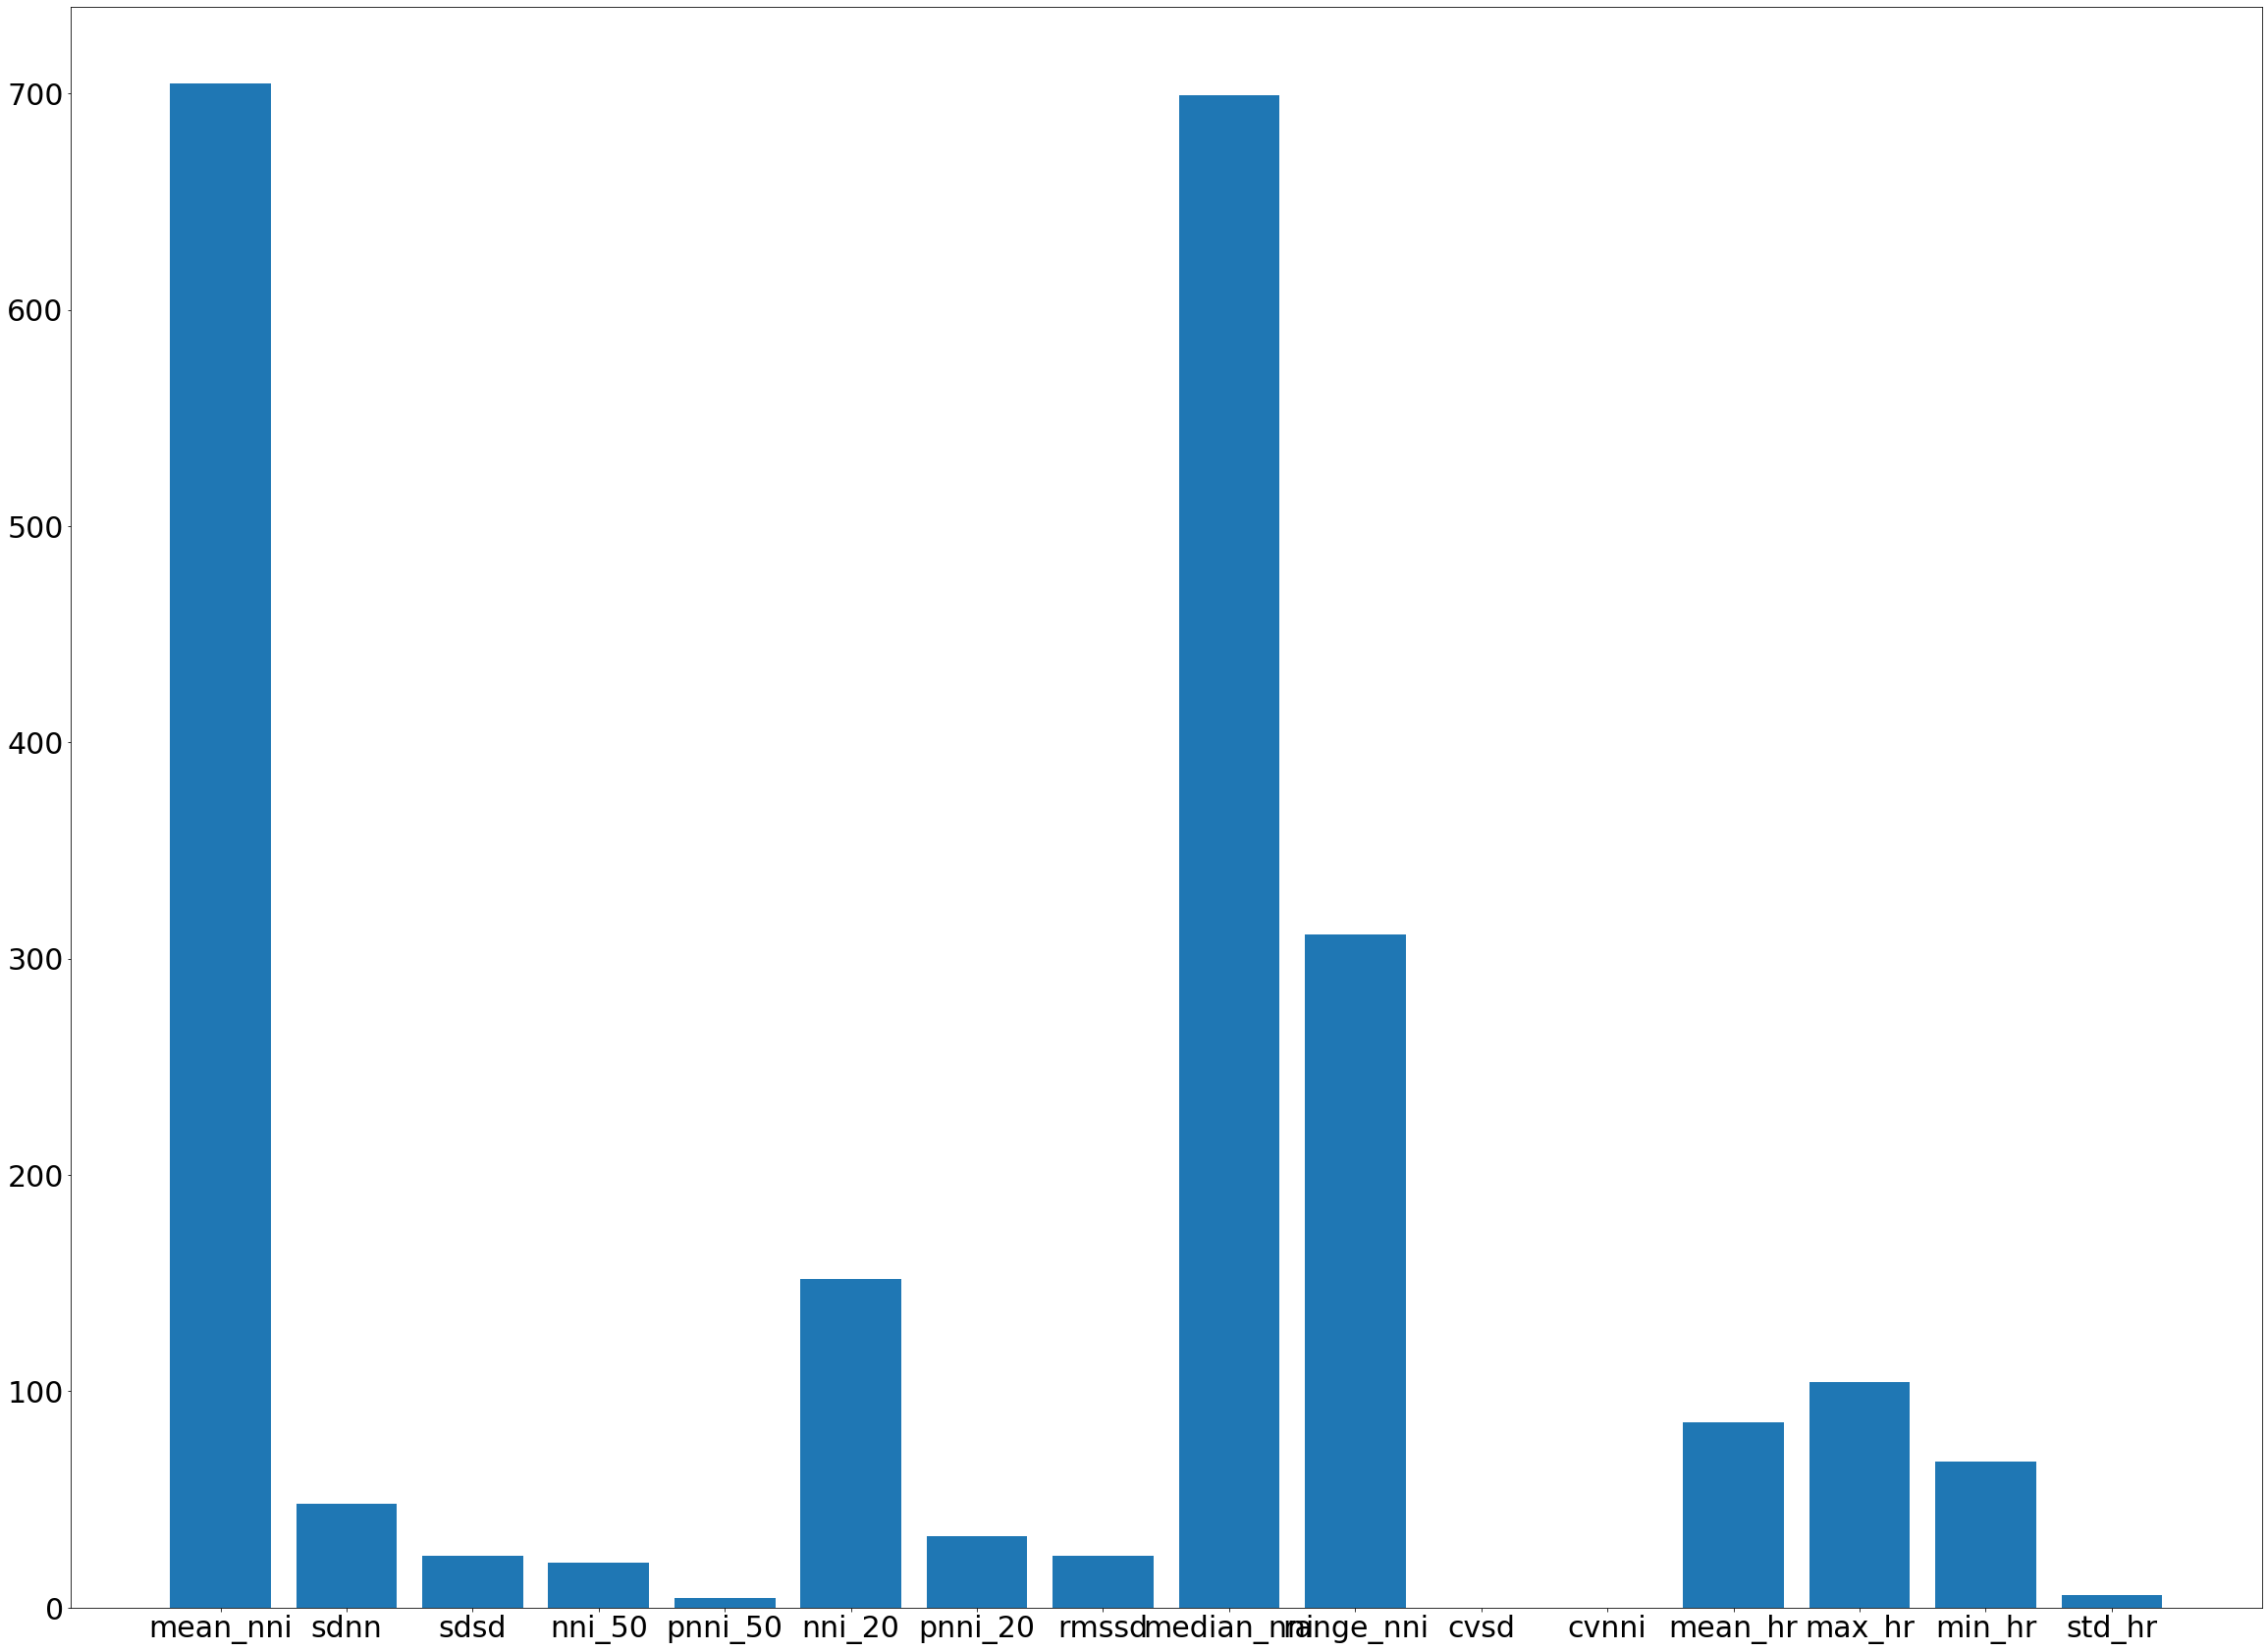

In [31]:
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.bar(range(len(time_domain_features)), list(time_domain_features.values()), align='center')
plt.xticks(range(len(time_domain_features)), list(time_domain_features.keys()))